In [44]:
import numpy as np
import pandas as pd

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv(r'../data/sample_submission.csv')

members = pd.read_csv('../data/members.csv')
songs = pd.read_csv('../data/songs.csv')
song_extra_info = pd.read_csv('../data/song_extra_info.csv')

In [3]:
members.head(2)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622


In [4]:
songs.head(2)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0


In [5]:
song_extra_info.head(2)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015


## Train, Test

In [6]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1


In [8]:
# Количество уникальных user
train_users = set(train['msno'])
test_users = set(test['msno'])

intersection = train_users & test_users
unique_train = train_users - intersection
unique_test = test_users - intersection
print('Пересечение: {}'.format(len(intersection)),
      '\nУникальные для трейна: {}'.format(len(unique_train)),
      '\nУникальные для теста: {}'.format(len(unique_test)))

Пересечение: 21483 
Уникальные для трейна: 9272 
Уникальные для теста: 3648


In [9]:
# Количество уникальных пар user-item
train_pairs = set(set(train['msno']+train['song_id']))
test_pairs = set(set(test['msno']+test['song_id']))

intersection = train_pairs & test_pairs
unique_train = train_pairs - intersection
unique_test = test_pairs - intersection
print('Пересечение: {}'.format(len(intersection)),
      '\nУникальные для трейна: {}'.format(len(unique_train)),
      '\nУникальные для теста: {}'.format(len(unique_test)))
# Большое количество пар user-item повторяются в test

Пересечение: 320446 
Уникальные для трейна: 7056972 
Уникальные для теста: 2236344


# Target encoding features

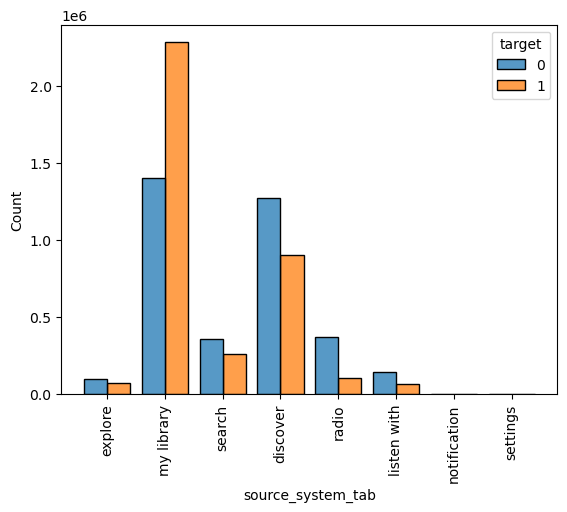

In [10]:
plt.xticks(rotation=90)
sns.histplot(x='source_system_tab', hue='target', data=train,
             multiple='dodge', shrink=0.8)
plt.show()

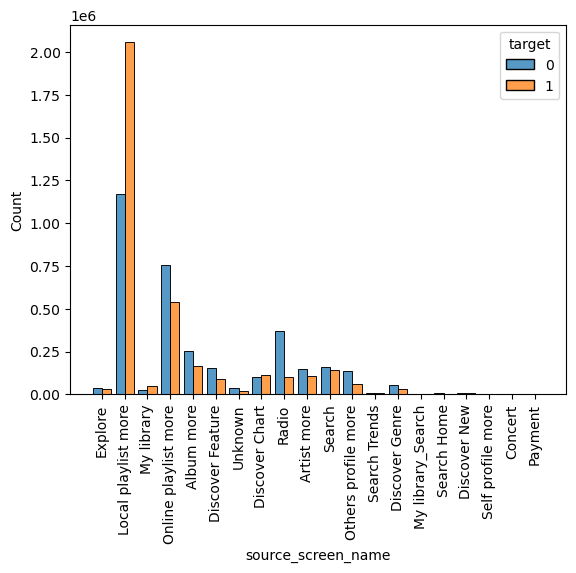

In [11]:
plt.xticks(rotation=90)
sns.histplot(x='source_screen_name', hue='target', data=train,
             multiple='dodge', shrink=0.8)
plt.show()

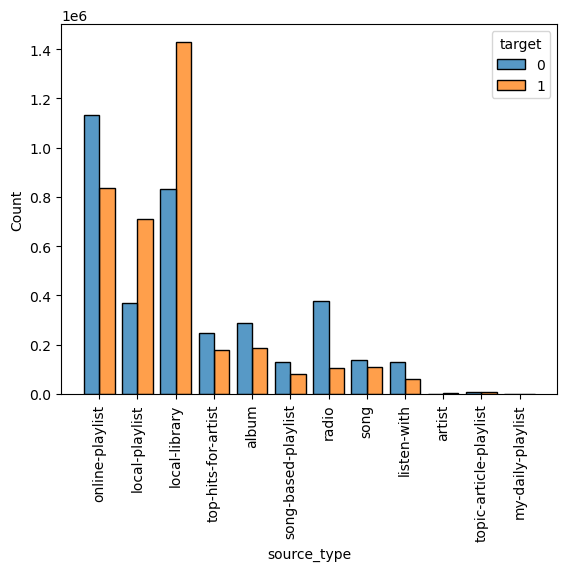

In [12]:
plt.xticks(rotation=90)
sns.histplot(x='source_type', hue='target', data=train,
             multiple='dodge', shrink=0.8)
plt.show()

Выявлена зависимость между вероятностью повторного прослушивания (target) и местом, в котором аудиозапись была впервые прослушана (source_system_tab, source_screen_name, source_type)

## Members

In [13]:
members['registration_year'] = members['registration_init_time'].map(lambda x: int(str(x)[:4]))
members['registration_month'] = members['registration_init_time'].map(lambda x: int(str(x)[4:6]))

members['expiration_year'] = members['expiration_date'].map(lambda x: int(str(x)[:4]))
members['expiration_month'] = members['expiration_date'].map(lambda x: int(str(x)[4:6]))

train = pd.merge(train, members, on='msno', how='left')
members.head(3)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_year,registration_month,expiration_year,expiration_month
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920,2011,8,2017,9
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622,2015,6,2017,6
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712,2016,4,2017,7


<Axes: xlabel='city', ylabel='Count'>

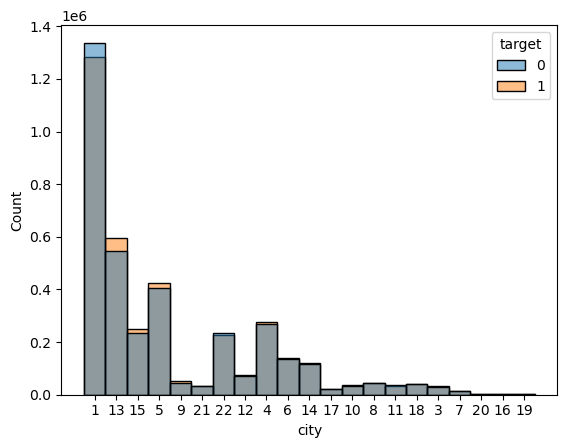

In [14]:
data = train[['city', 'target']].copy()
data['city'] = data['city'].astype(str)
sns.histplot(x='city', hue='target', data=data)

<Axes: xlabel='bd', ylabel='Count'>

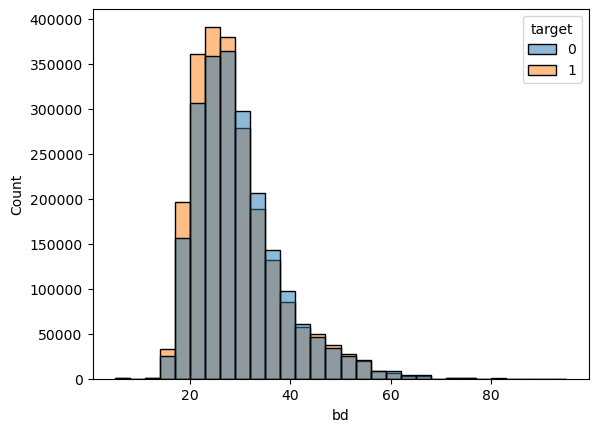

In [15]:
sns.histplot(x='bd', hue='target', data=train.loc[(train.bd < 100) & (train.bd > 3)], bins=30)

<Axes: xlabel='registered_via', ylabel='Count'>

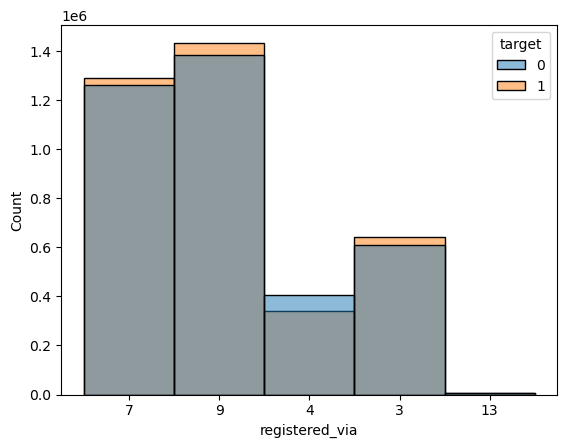

In [16]:
data = train[['registered_via', 'target']].copy()
data['registered_via'] = data['registered_via'].astype(str)
sns.histplot(x='registered_via', hue='target', data=data)

<Axes: xlabel='registration_year', ylabel='Count'>

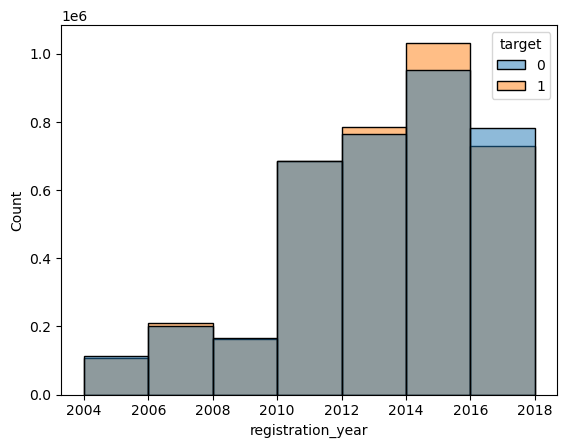

In [17]:
sns.histplot(x='registration_year', hue='target', data=train, binwidth=2)

<Axes: xlabel='expiration_year', ylabel='Count'>

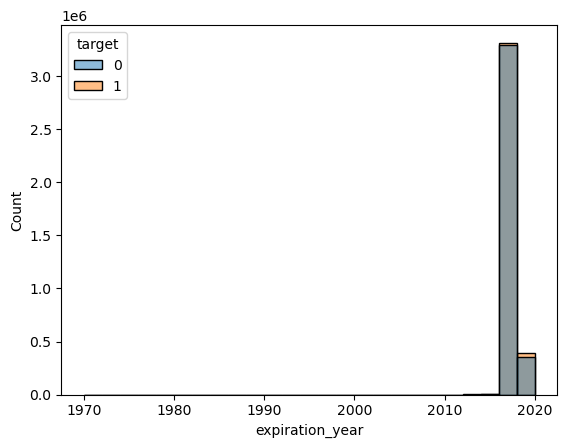

In [18]:
sns.histplot(x='expiration_year', hue='target', data=train, binwidth=2)

Не выявлено значительных зависимостей между целевой переменной и параметрами пользователя (город, возраст, дата регистрации, способ регистрации и т.д.)

## Songs

In [19]:
train = pd.merge(train, songs, on='song_id', how='left')
songs.head(4)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0


<Axes: xlabel='song_length', ylabel='Count'>

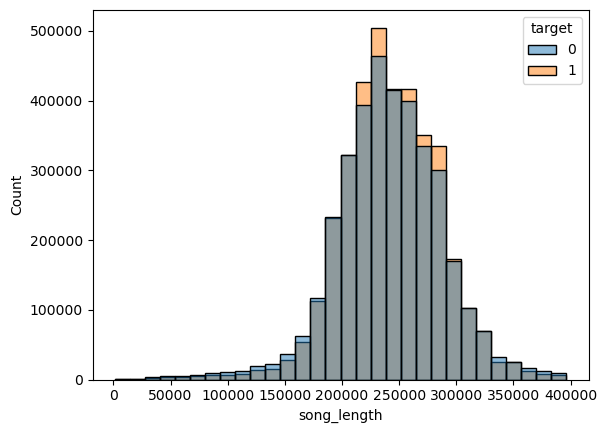

In [20]:
sns.histplot(x='song_length', hue='target',
             data=train.loc[train.song_length < train.song_length.quantile(0.99)],
             bins=30)

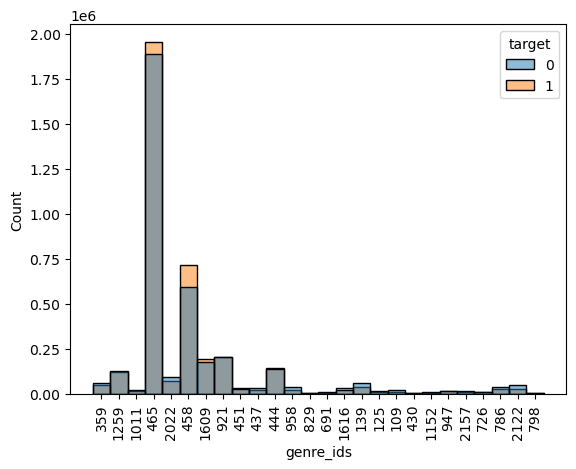

In [21]:
train['genre_ids'] = train['genre_ids'].map(
    lambda x: (x.split('|') if isinstance(x, str) else [])
)
data = train[['genre_ids', 'target']].explode('genre_ids')
data = data.reset_index(drop=True)

value_counts = data.genre_ids.value_counts()
to_keep = value_counts[value_counts >= 10000].index

plt.xticks(rotation=90)
sns.histplot(x='genre_ids', hue='target', data=data[data.genre_ids.isin(to_keep)])

# keep only first genre
train['genre_ids'] = train['genre_ids'].map(lambda x: (x[0] if x else np.nan))

In [22]:
train['target_artist'] = train.groupby('artist_name')['target'].transform(np.mean)
train['target_composer'] = train.groupby('composer')['target'].transform(np.mean)
train['target_lyricist'] = train.groupby('lyricist')['target'].transform(np.mean)

<Axes: xlabel='target_artist', ylabel='Count'>

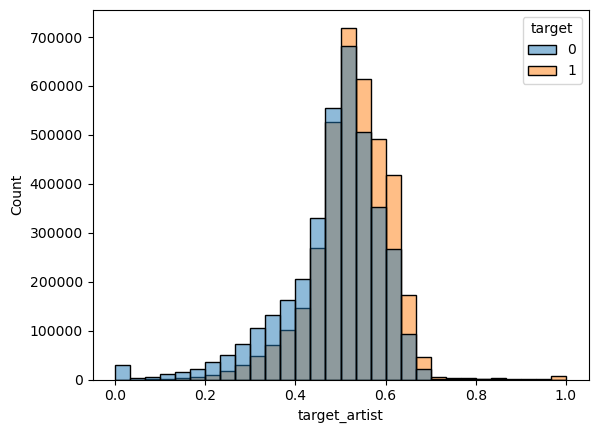

In [23]:
sns.histplot(x='target_artist', hue='target', data=train, bins=30)

<Axes: xlabel='target_composer', ylabel='Count'>

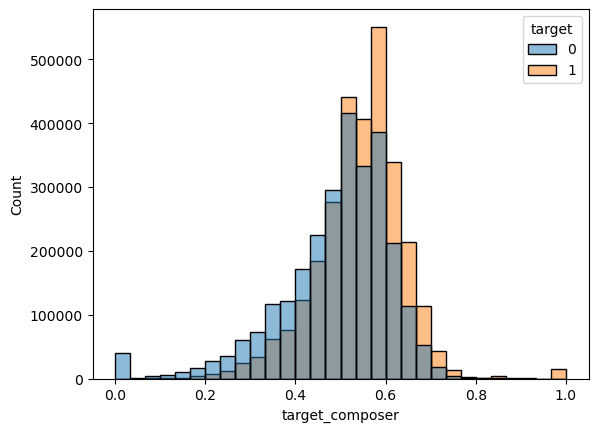

In [24]:
sns.histplot(x='target_composer', hue='target', data=train, bins=30)

<Axes: xlabel='target_lyricist', ylabel='Count'>

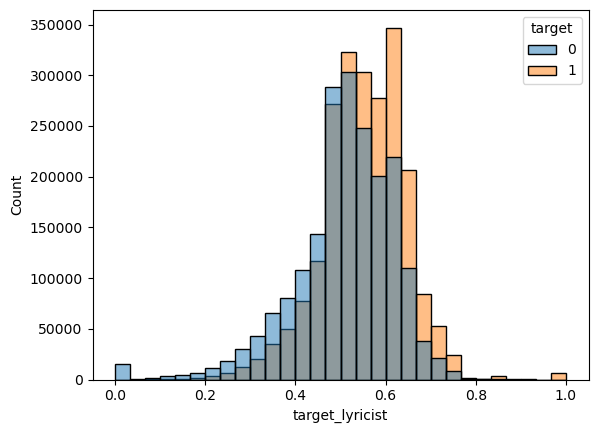

In [25]:
sns.histplot(x='target_lyricist', hue='target', data=train, bins=30)

<Axes: xlabel='language', ylabel='Count'>

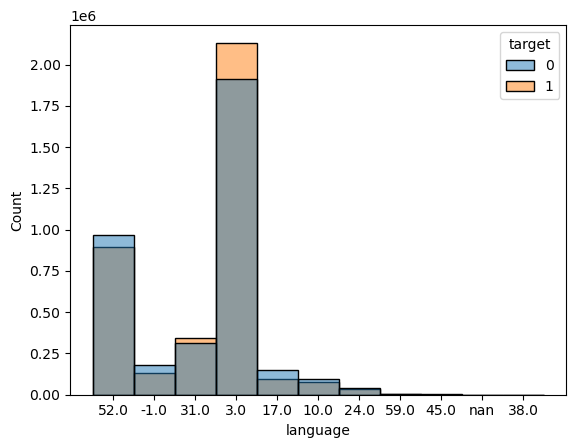

In [26]:
data = train[['language', 'target']].copy()
data['language'] = data['language'].astype(str)
sns.histplot(x='language', hue='target', data=data)

## Song extra info

In [27]:
song_extra_info.head(3)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303


Пока не будем затрагивать эту таблицу

## P(predictor|user) like features

In [28]:
def conditional_probabilities(predictor, condition, data):
    total_counts = data.groupby(condition).size().reset_index(name='count')
    predictor_counts = data.groupby([condition, predictor]).size().reset_index(name=f'{predictor}_count')
    predictor_counts = pd.merge(predictor_counts, total_counts, on=condition)
    predictor_counts[f'{predictor}_probability'] = predictor_counts[f'{predictor}_count'] / predictor_counts['count']
    predictor_counts = predictor_counts.drop([f'{predictor}_count', 'count'], axis=1)
    return predictor_counts

predictors = ['source_system_tab', 'source_screen_name', 'source_type',
              'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
for predictor in predictors:
    predictor_counts = conditional_probabilities(predictor, 'msno', train)
    train = pd.merge(train, predictor_counts, on=['msno', predictor], how='left')
    train[f'{predictor}_probability'] = train[f'{predictor}_probability'].fillna(0)

In [29]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_year,registration_month,expiration_year,expiration_month,song_length,genre_ids,artist_name,composer,lyricist,language,target_artist,target_composer,target_lyricist,source_system_tab_probability,source_screen_name_probability,source_type_probability,genre_ids_probability,artist_name_probability,composer_probability,lyricist_probability,language_probability
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,2012,1,2017,10,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,0.463158,0.49499,NaN,0.161132,0.122301,0.25930,0.029577,0.000544,0.000363,0.0,0.530938
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,2011,5,2017,9,284584.0,1259,Various Artists,NaN,NaN,52.0,0.509851,NaN,NaN,0.885852,0.885852,0.21865,0.067524,0.038585,0.000000,0.0,0.183280
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,2011,5,2017,9,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,0.214533,0.50000,NaN,0.885852,0.885852,0.21865,0.067524,0.003215,0.001608,0.0,0.183280


<Axes: xlabel='source_system_tab_probability', ylabel='Count'>

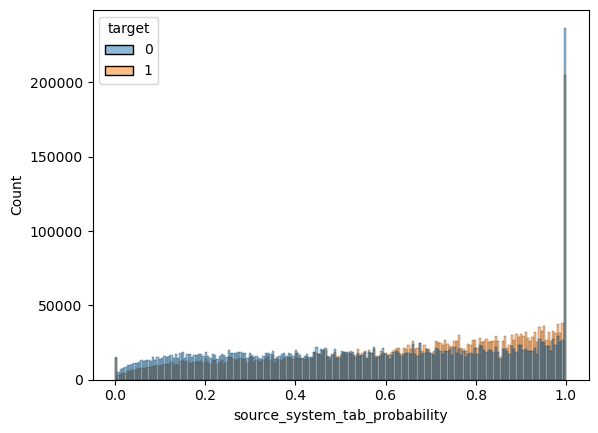

In [31]:
sns.histplot(x=f'{predictors[0]}_probability', hue='target', data=train)

<Axes: xlabel='source_screen_name_probability', ylabel='Count'>

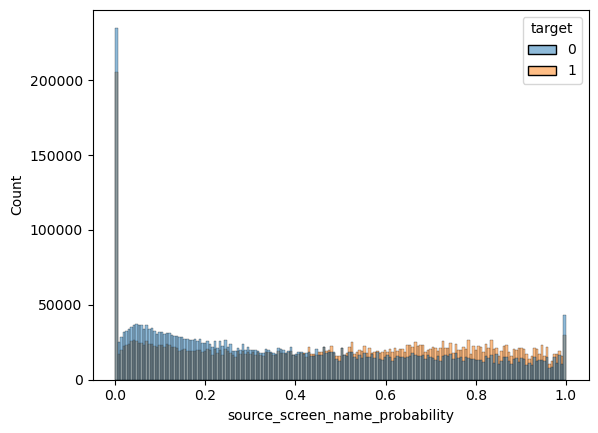

In [32]:
sns.histplot(x=f'{predictors[1]}_probability', hue='target', data=train)

<Axes: xlabel='source_type_probability', ylabel='Count'>

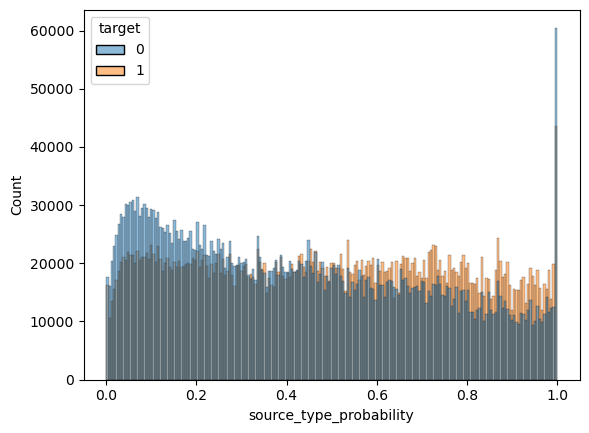

In [33]:
sns.histplot(x=f'{predictors[2]}_probability', hue='target', data=train)

<Axes: xlabel='genre_ids_probability', ylabel='Count'>

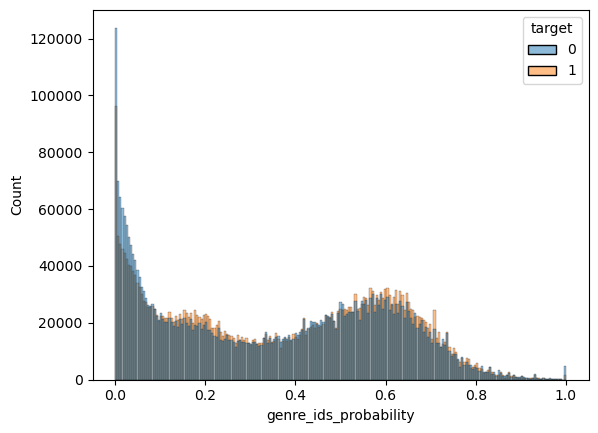

In [34]:
sns.histplot(x=f'{predictors[3]}_probability', hue='target', data=train)

<Axes: xlabel='artist_name_probability', ylabel='Count'>

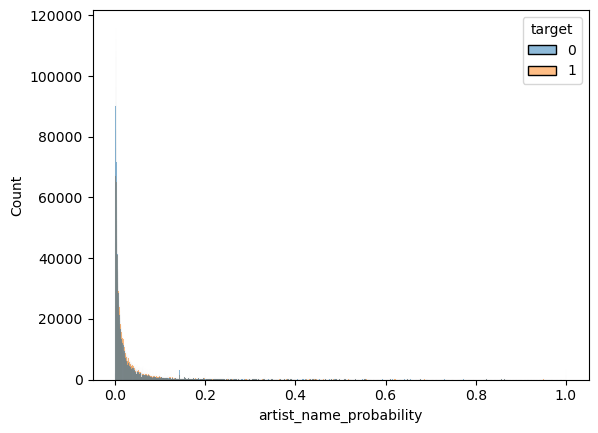

In [35]:
sns.histplot(x=f'{predictors[4]}_probability', hue='target', data=train)

<Axes: xlabel='composer_probability', ylabel='Count'>

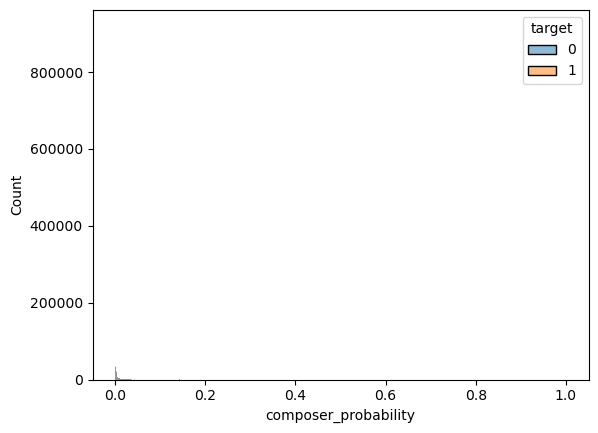

In [36]:
sns.histplot(x=f'{predictors[5]}_probability', hue='target', data=train)

<Axes: xlabel='lyricist_probability', ylabel='Count'>

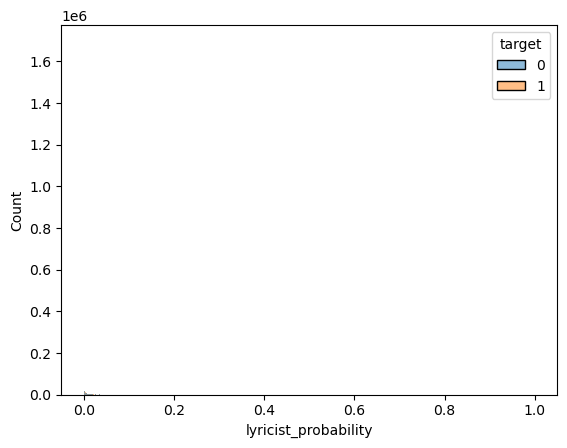

In [37]:
sns.histplot(x=f'{predictors[6]}_probability', hue='target', data=train)

<Axes: xlabel='language_probability', ylabel='Count'>

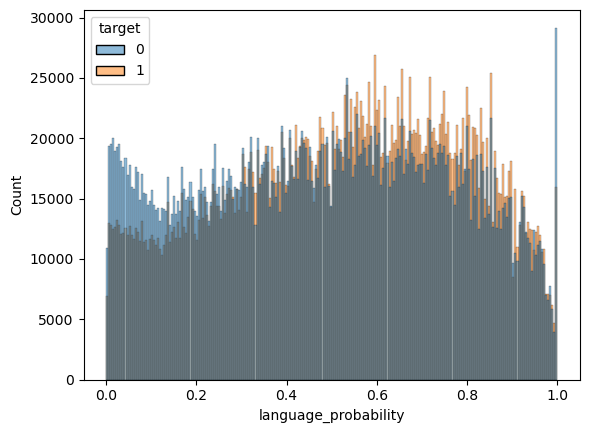

In [38]:
sns.histplot(x=f'{predictors[7]}_probability', hue='target', data=train)

In [41]:
predictors = ['source_system_tab', 'source_screen_name', 'source_type']
for predictor in predictors:
    predictor_counts = conditional_probabilities(predictor, 'song_id', train)
    train = pd.merge(train, predictor_counts, on=['song_id', predictor], how='left')
    train[f'{predictor}_probability_y'] = train[f'{predictor}_probability_y'].fillna(0)

<Axes: xlabel='source_system_tab_probability_y', ylabel='Count'>

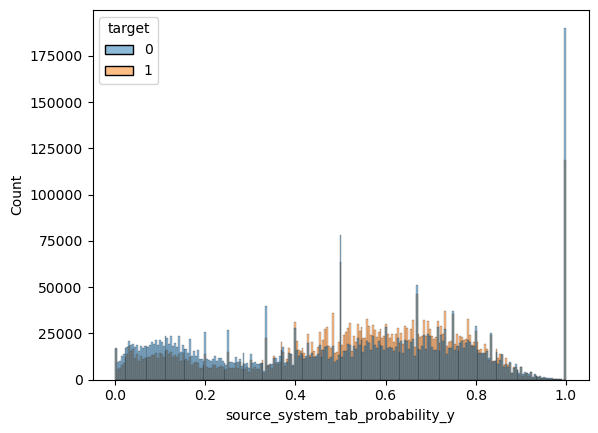

In [45]:
sns.histplot(x=f'{predictors[0]}_probability_y', hue='target', data=train)

<Axes: xlabel='source_screen_name_probability_y', ylabel='Count'>

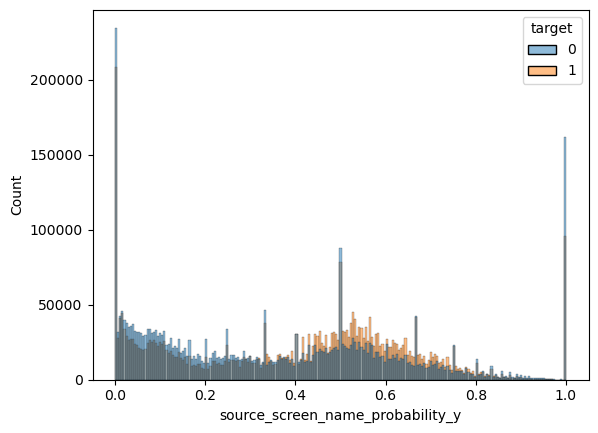

In [46]:
sns.histplot(x=f'{predictors[1]}_probability_y', hue='target', data=train)

<Axes: xlabel='source_type_probability_y', ylabel='Count'>

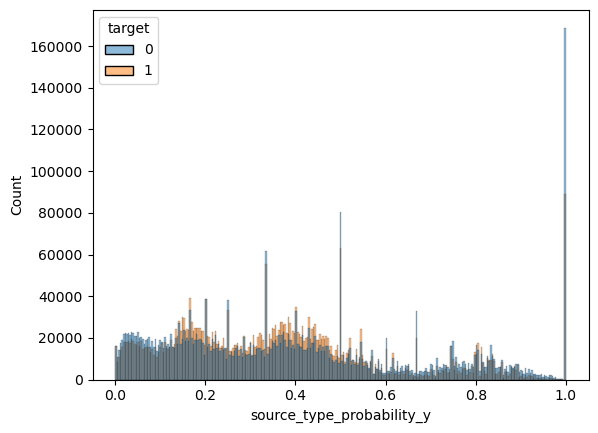

In [47]:
sns.histplot(x=f'{predictors[2]}_probability_y', hue='target', data=train)